### 기말프로젝트
# Show Me the Movie

In [1]:
# pip install WordCloud
# pip install tabulate

In [2]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import re
from tqdm import tqdm
import datetime, time

from io import BytesIO
from PIL import Image

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [3]:
def checkTime(func):
    import time
    def new(*args, **kwargs):
        s = time.time()
        func(*args, **kwargs)
        e = time.time()
        print(f"전체 실행시간: {e-s:.5f}초")
    
    return new

In [4]:
class Movie(object):

    def __init__(self, title):
        self.base_url = 'https://movie.naver.com/'
        self.code, self.title, self.image, self.genre, self.director, self.actor = "", title, "", "", "", ""
        self.movie_review = pd.DataFrame(columns = ['star', 'review'])

    @staticmethod
    def now():
        release = pd.DataFrame(columns = ['title','director', 'genre'])
        # 현재 상영 영화
        url = 'https://movie.naver.com/movie/running/current.nhn?order=reserve'
        html = requests.get(url).content
        soup = BeautifulSoup(html, 'lxml')
        title, genre, director = "", "", ""

        current_raw = soup.find('ul', 'lst_detail_t1').find_all('li')

        for i in range(10):
            try:
                title = current_raw[i].img['alt']
                genre = ", ".join(map(lambda x: x.text, current_raw[i].find_all('dd')[4]\
                                                        .find_all('span', 'link_txt')[0].find_all('a')))
                director = current_raw[i].find_all('dd')[3].find_all('span', 'link_txt')[1].text.split(',')
                director = ", ".join(map(lambda x: x.strip(), director))
            except:
                print(f"'{i+1}번째 상영작'을 크롤링하는 중에 오류가 발생하였습니다.")
                print(f"title: {title}\ngenre: {genre}\ndirector: {director}\n")

            finally:
                release = release.append({'title':title,'director':director, 'genre':genre}, 
                                                   ignore_index = True)
        return release
        
    def get_codentitle(self):
        driver = webdriver.Chrome(executable_path = '/Users/yejin/Desktop/chromedriver')
        driver.get(self.base_url)
        search = driver.find_element_by_css_selector('#ipt_tx_srch')
        search.send_keys(self.title)
        time.sleep(1)
        self.title = driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1)')\
                            .get_attribute('data-title')
        self.code = driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1) > a')\
                          .get_attribute('href')
        self.code = re.search('(?<=)[0-9]+', self.code).group()

        driver.quit()

    
    def get_reviews(self):
        Movie.get_codentitle(self)
        
        ### 네이버 리뷰, 평점 크롤링
        driver = webdriver.Chrome(executable_path = '/Users/yejin/Desktop/chromedriver')
        driver.get(f'{self.base_url}movie/bi/mi/point.nhn?code={self.code}')
        driver.switch_to.frame("pointAfterListIframe")

        # 1페이지부터 50페이지까지
        try:
            for p in tqdm(range(1, 51)):
                driver.find_element_by_css_selector(f'a#pagerTagAnchor{p}').click()

                # 1페이지에 10개씩
                for i in range(1, 11):
                    star = int(driver.find_element_by_css_selector(f'body > div > div > div.score_result > ul > \
                                                               li:nth-child({i}) > div.star_score > em').text)
                    review = driver.find_element_by_css_selector(f'#_filtered_ment_{i-1}').text
                    
                    if review == "": 
                        #스포일러로 분류된 리뷰
                        try:
                            review = driver.find_element_by_css_selector(f'#_unfold_ment{i-1} > a')\
                            .get_attribute('data-src')
                        except:
                            review = ""

                    # 리뷰 저장
                    self.movie_review = self.movie_review.append({"star": star, 'review': review}, 
                                                                 ignore_index = True)
        except:
            self.movie_review = self.movie_review.append({"star": star, 'review': review}, ignore_index = True)

        driver.quit()
    
    
    def get_info(self):
        ## 감독, 배우, 장르, 포스터 크롤링
        url = self.base_url + f'movie/bi/mi/basic.nhn?code={self.code}'
        html = requests.get(url).content
        soup = BeautifulSoup(html, 'lxml')
        
        self.image = soup.find('meta', property = 'og:image').get('content')
        self.genre = soup.find('p', 'info_spec').find_all('a')[0].text
        names = list(map(lambda x: x.text, soup.find('div', 'info_spec2').find_all('a')[:-1]))
        for name in names:
            if ('(' or ')') in name:
                self.actor += ", " + name[:name.find('(')]
            else:
                self.director += ", " + name
        
        self.actor = self.actor[2:]
        self.director = self.director[2:]
                

In [5]:
class Show_movie(object):
    
    def __init__(self, title):
        Movie.__init__(self, title)
        self.pos_review = []
        self.neg_review = []
        print(f'[{self.title}] 관련 정보를 크롤링 중입니다...')
        Movie.get_reviews(self)
        Movie.get_info(self)
    
    def review(self):
        df = pd.DataFrame(self.movie_review.star.value_counts()).reset_index()
        stars = pd.DataFrame({'index':range(1, 11)})
        stars = stars.merge(df, how = 'left').fillna(0).rename(columns = {'index': 'star', 'star':'review'})
        sns.set(rc={'figure.figsize':(14,7), 'font.family': "AppleGothic"})
        plt.style.use('ggplot')
                
        sns.set_palette('RdYlGn', 10)
        sns.barplot(data = stars, x = 'star', y = 'review')
        plt.title(f'영화 \'{self.title}\' 평점 분포')
        plt.show()
        
    
    def pos_neg(self):
        ## KoNLPy의 Okt()로 토큰화
        ## Noun, Adjective, KoreanParticle 사용
        okt = Okt()
        print('워드 클라우드를 생성 중입니다...')
        korean_stopwords = open('./korean_stopwords.txt', 'rt').read()
        
        self.pos_review = [w for r in self.movie_review[self.movie_review.star > 7].review
                             for w, t in okt.pos(r) if t in ['Noun', 'KoreanParticle', 'Adjective']
                             if (w not in korean_stopwords) and (w != '영화')]
        self.neg_review = [w for r in self.movie_review[self.movie_review.star < 4].review
                             for w, t in okt.pos(r) if t in ['Noun', 'KoreanParticle', 'Adjective']
                             if (w not in korean_stopwords) and (w != '영화')]
          
    
    def word_cloud(self):
        Show_movie.pos_neg(self)
        
        up_url = 'https://cdn1.iconfinder.com/data/icons/hand-icon/1792/thumbs-up-512.png'
        down_url = 'https://cdn1.iconfinder.com/data/icons/hand-icon/1792/thumbs-down-512.png'
        
        # 긍정 리뷰 word_cloud
        p_icon = Image.open(requests.get(up_url, stream=True).raw)

        p_mask = Image.new("RGB", p_icon.size, (255,255,255))
        p_mask.paste(p_icon,p_icon)
        p_mask = np.array(p_mask)
        
        p_count = Counter(self.pos_review)
        if len(p_count) >= 900: p_ranked_tags = p_count.most_common(len(p_count) // 10)
        else: p_ranked_tags = p_count.most_common(len(p_count))
        
        try:
            pos_wc = WordCloud(max_font_size = 200, font_path = 'AppleGothic', mask = p_mask,
                               colormap = 'Greens', background_color = 'white', 
                               width = 800, height = 800)
            pos_wc.generate_from_frequencies(dict(p_ranked_tags))
        except:
            pos_wc = Image.open('./pos.png')
        
        # 부정 리뷰 word_cloud
        n_icon = Image.open(requests.get(down_url, stream=True).raw)
                
        n_mask = Image.new("RGB", n_icon.size, (255,255,255))
        n_mask.paste(n_icon,n_icon)
        n_mask = np.array(n_mask)
        
        n_count = Counter(self.neg_review)
        if len(n_count) >= 900: n_ranked_tags = n_count.most_common(len(n_count) // 10)
        else: n_ranked_tags = n_count.most_common(len(n_count))
        
        try:
            neg_wc = WordCloud(max_font_size = 200, font_path = 'AppleGothic', mask = n_mask,
                               colormap = "Reds", background_color = 'white', 
                               width = 800, height = 800)
            neg_wc.generate_from_frequencies(dict(n_ranked_tags))
        except:
            neg_wc = Image.open('./neg.png')

        
        fig,ax = plt.subplots(1,2, figsize=(14,7))
        fig.tight_layout()
        ax[0].imshow(pos_wc)
        ax[0].axis('off')
        ax[1].imshow(neg_wc)
        ax[1].axis('off')
        plt.show()
    
    def movie_info(self):
        url = self.image
        res = requests.get(url)
        poster = Image.open(BytesIO(res.content))
        
        plt.figure(figsize=(7,14))
        plt.imshow(poster)
        plt.axis('off')
        plt.show()        
        
        print("영화 제목:", self.title)
        print('장르: ', self.genre)
        print("감독:", self.director)
        print("출연진:", self.actor)
        print(f'리뷰 평점({len(self.movie_review)}개): {sum(self.movie_review.star) / len(self.movie_review):.2f}')       

In [6]:
@checkTime
def main():
    choice = -1
    while 1:
        MN = pd.DataFrame({'MENU': ['END', 'Now playing', 'Search']})
        print("*"*100)
        print()
        print(tabulate(MN, headers='keys', tablefmt='pretty'))
        
        choice = int(input('메뉴 번호를 선택하세요: '))
        print()
        if choice == 0:
            print('프로그램을 종료합니다.')
            break
        elif choice == 1:
            today = Movie.now()
            print(f'{datetime.date.today()} 현재 상영작 TOP10 (예매순)')
            display(today)
        elif choice == 2:
            title = input('검색하고 싶은 영화 제목을 입력하세요: ')
            movie = Show_movie(title)
            
            while 1:
                print()
                print('='*100)
                mn = pd.DataFrame({'movie_menu': ['BACK', 'Info', 'Ratings', 'Word Cloud']})
                print(tabulate(mn, headers='keys', tablefmt='presto'))
                choice2 = int(input('메뉴를 선택하세요: '))
                print()
                if choice2 == 1:
                    movie.movie_info()
                if choice2 == 2:
                    movie.review()
                if choice2 == 3:
                    movie.word_cloud()
                if choice2 == 0:
                    break

        else:
            print('잘못된 번호입니다.')

****************************************************************************************************

+---+-------------+
|   |    MENU     |
+---+-------------+
| 0 |     END     |
| 1 | Now playing |
| 2 |   Search    |
+---+-------------+

2021-08-10 현재 상영작 TOP10 (예매순)


,title,director,genre
0,모가디슈,류승완,"액션, 드라마"
1,방법: 재차의,김용완,"미스터리, 스릴러"
2,더 수어사이드 스쿼드,제임스 건,"액션, 모험, 판타지, 미스터리, SF"
3,보스 베이비 2,톰 맥그라스,"애니메이션, 코미디, 모험"
4,정글 크루즈,자움 콜렛 세라,"액션, 모험"
5,더 그레이트 샤크,마틴 윌슨,"공포, 스릴러"
6,극장판 도라에몽: 진구의 신공룡,이마이 카즈아키,"애니메이션, 모험"
7,그린 나이트,데이빗 로워리,"모험, 드라마, 판타지"
8,블랙 위도우,케이트 쇼트랜드,"액션, 모험, SF"
9,우리는 매일매일,강유가람,다큐멘터리


****************************************************************************************************

+---+-------------+
|   |    MENU     |
+---+-------------+
| 0 |     END     |
| 1 | Now playing |
| 2 |   Search    |
+---+-------------+

[월터의 상상] 관련 정보를 크롤링 중입니다...


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]



    | movie_menu
----+--------------
  0 | BACK
  1 | Info
  2 | Ratings
  3 | Word Cloud



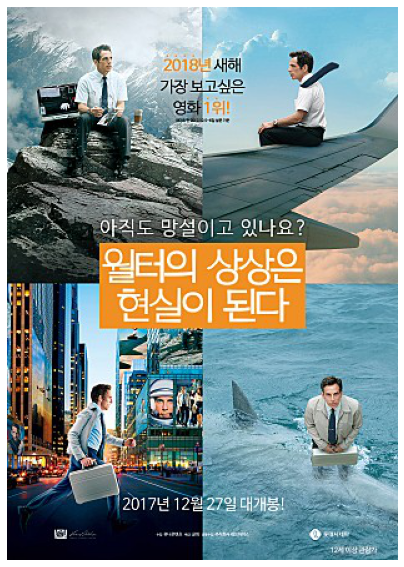

영화 제목: 월터의 상상은 현실이 된다
장르:  모험
감독: 벤 스틸러
출연진: 벤 스틸러, 크리스틴 위그, 숀 펜
리뷰 평점(500개): 9.48

    | movie_menu
----+--------------
  0 | BACK
  1 | Info
  2 | Ratings
  3 | Word Cloud



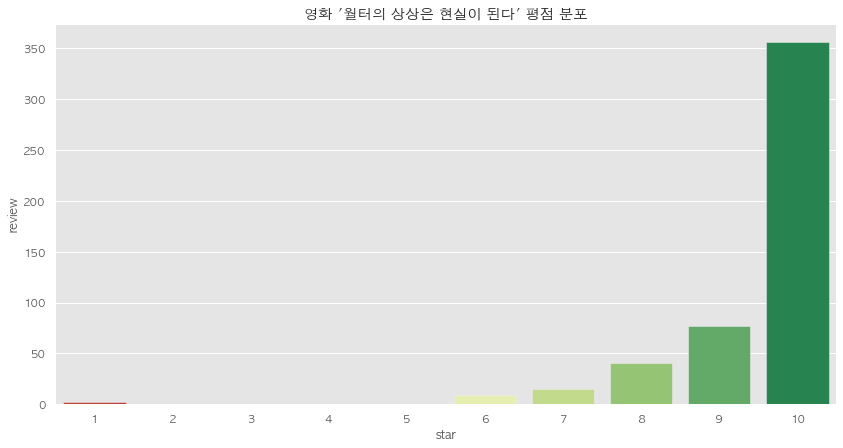


    | movie_menu
----+--------------
  0 | BACK
  1 | Info
  2 | Ratings
  3 | Word Cloud

워드 클라우드를 생성 중입니다...


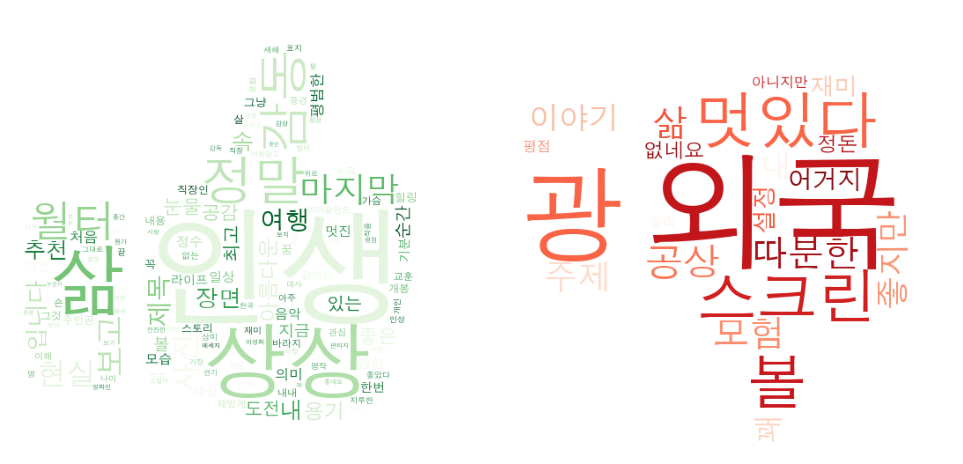


    | movie_menu
----+--------------
  0 | BACK
  1 | Info
  2 | Ratings
  3 | Word Cloud

****************************************************************************************************

+---+-------------+
|   |    MENU     |
+---+-------------+
| 0 |     END     |
| 1 | Now playing |
| 2 |   Search    |
+---+-------------+

프로그램을 종료합니다.
전체 실행시간: 73.25129초


In [7]:
main()

## main함수 실행 안함

In [8]:
print(f'{datetime.date.today()} 현재 상영작 TOP10 (예매순)')
display(Movie.now())

2021-08-10 현재 상영작 TOP10 (예매순)


,title,director,genre
0,모가디슈,류승완,"액션, 드라마"
1,방법: 재차의,김용완,"미스터리, 스릴러"
2,더 수어사이드 스쿼드,제임스 건,"액션, 모험, 판타지, 미스터리, SF"
3,보스 베이비 2,톰 맥그라스,"애니메이션, 코미디, 모험"
4,정글 크루즈,자움 콜렛 세라,"액션, 모험"
5,더 그레이트 샤크,마틴 윌슨,"공포, 스릴러"
6,극장판 도라에몽: 진구의 신공룡,이마이 카즈아키,"애니메이션, 모험"
7,그린 나이트,데이빗 로워리,"모험, 드라마, 판타지"
8,블랙 위도우,케이트 쇼트랜드,"액션, 모험, SF"
9,우리는 매일매일,강유가람,다큐멘터리


In [9]:
tenet = Show_movie('테넷')

[테넷] 관련 정보를 크롤링 중입니다...


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


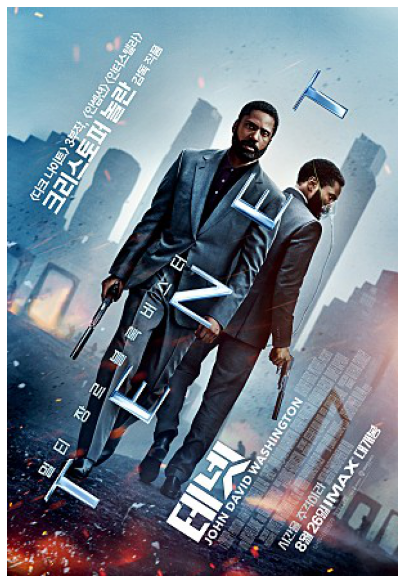

영화 제목: 테넷
장르:  액션
감독: 크리스토퍼 놀란
출연진: 존 데이비드 워싱턴, 로버트 패틴슨, 엘리자베스 데비키
리뷰 평점(500개): 5.15


In [10]:
tenet.movie_info()

워드 클라우드를 생성 중입니다...


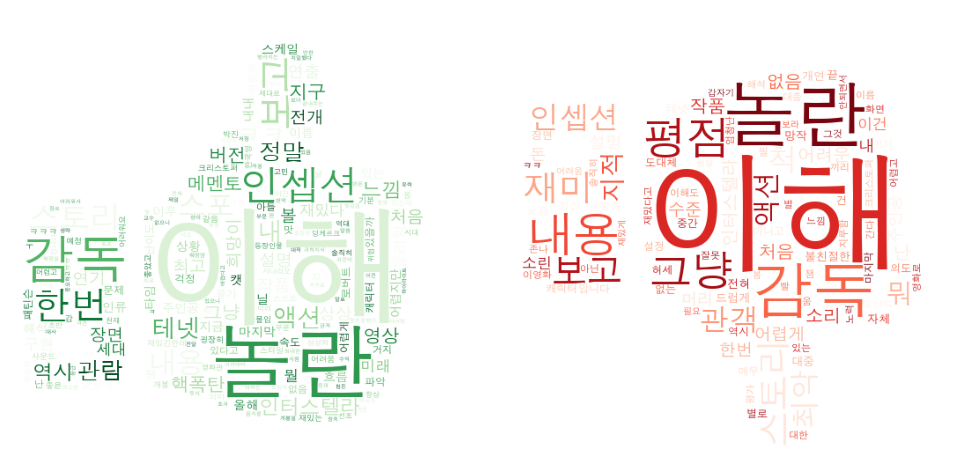

In [11]:
tenet.word_cloud()

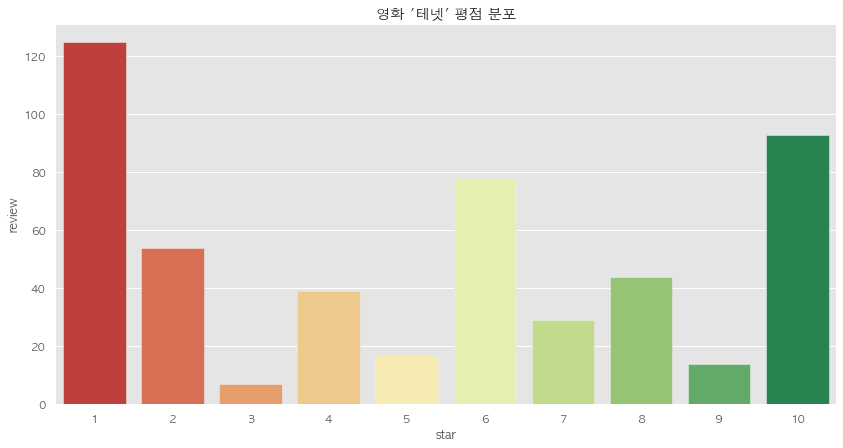

In [12]:
tenet.review()